## Problem 6.12
In this problem we study the velocity-stress formulation of the 1D wave equation using a pseudospectral method. First let us define a function to produce our initial condition, setting the velocity and stress:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy


def init_condition(x, v, sigma):
    sigma[:] = 0
    v = -0.2*(x-50) * np.exp(-0.1 * (x-50)**2)
    return v, sigma

Next we can define the domain and properties of the system. Note that by the nature of a pseudospectral method, the first and last points of the domain are identical. Here, we create an array of $N+1$ length for plotting purposes, with the understanding that the first and last nodes will be the same. 

In [2]:
L            = 100       # domain size
dx           = 0.10      # grid spacing
dirichlet_bc = True     # switch for BC

# Here x goes from 0 (j=0) to 99.9 (j=N-1)
# and therefore has length of N
x =  np.arange(0, L+dx, dx)
N = len(x)

# Homogeneous domain
# rho = mu = 1 
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1

# Initialise some arrays of 
# velocity and stress at different
# timesteps
s = np.zeros(N, dtype='complex')
v = np.zeros(N, dtype='complex')

sgrad = np.zeros(N, dtype='complex')
vgrad = np.zeros(N, dtype='complex')

sold = np.zeros(N, dtype='complex')
vold = np.zeros(N, dtype='complex')

snew = np.zeros(N, dtype='complex')
vnew = np.zeros(N, dtype='complex')

Next let us define the timescheme. For a pseudospectral method, the Courant number should be below $1/(2\pi) \approx 0.16$ to ensure stability. Let us compute the timestep based on this condition, using a Courant number of 0.12. 

In [3]:
nsteps = 8000
dt     = 0.0315

# Compute dt 
cfl           = 0.12
max_wavespeed = np.max((mu/rho)**0.5)

dt = cfl*dx/max_wavespeed

Next, we can initialise the boundary conditions and run our simulation. In this case we have set ```dirichlet_bc = True``` such that the velocity is being fixed at the boundaries.

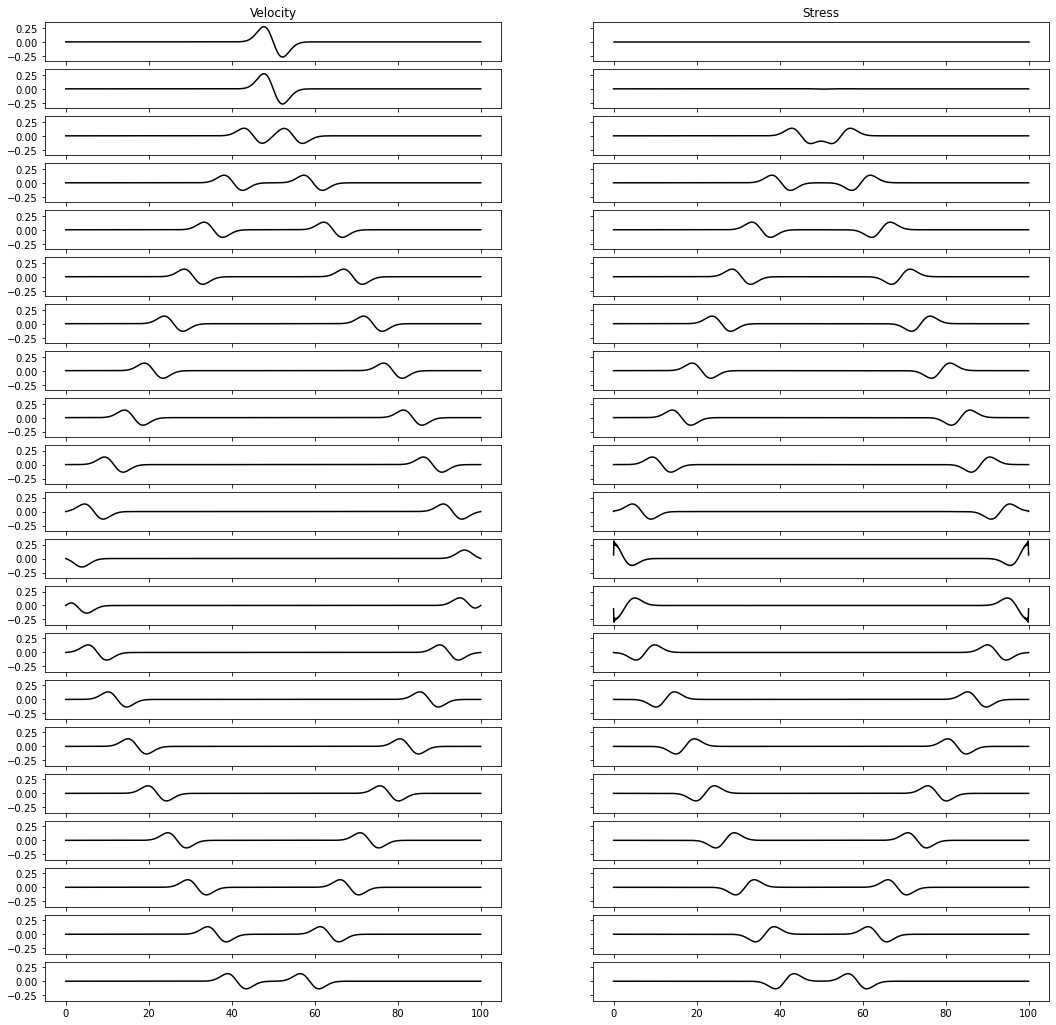

In [4]:
nplots  = 20
fig, ax = plt.subplots(nplots+1, 2, figsize=(18, 18), 
                       sharey=True, sharex=True)

# Set the initial condition
v, s       = init_condition(x, v, s)
vold, sold = init_condition(x, vold, sold)

# Plot the initial condition
ax[0,0].plot(x, v.real, 'k')
ax[0,1].plot(x, s.real, 'k')

# Add some labels
ax[0,0].set_ylim([-0.35, 0.35])
ax[0,0].set_title('Velocity')
ax[0,1].set_title('Stress')


# Compute the wavenumbers for FFT: 
kfft = np.fft.fftfreq(N, d=dx) * 2 * np.pi

iax    = 1
for istep in range(nsteps):

    # compute gradient of velocity using FFT
    vk    = np.fft.fft(v)
    vgrad = np.fft.ifft(1j * kfft * vk)

    # compute gradient of stress using FFT
    sk    = np.fft.fft(s)
    sgrad = np.fft.ifft(1j * kfft * sk)

    # Compute v-s at new timestep
    vnew = vold + sgrad*(2 * dt / rho)
    snew = sold + vgrad*(2 * dt * mu)

    if dirichlet_bc: 
        # Dirichlet
        v[0]     = 0
        v[-1]    = 0
        vnew[0]  = 0
        vnew[-1] = 0
    else: 
        # Neumann
        s[0]     = 0
        s[-1]    = 0
        snew[0]  = 0
        snew[-1] = 0
    
    # Update arrays: 
    vold[:] = v[:]
    sold[:] = s[:]
    v[:]    = vnew[:].real
    s[:]    = snew[:].real

    # Plot some timesteps
    if istep % (nsteps/nplots) == 0:
        ax[iax,0].plot(x, v.real, 'k')
        ax[iax,1].plot(x, s.real, 'k')
        iax +=1

We observe the expected behaviour in the velocity, where the wave reflects and changes polarity. Note, however, the non-physical nature of the stress at the boundary introduced by the periodic boundary condition.

### Heterogeneous model: 

Next let us turn to the heterogeneous case. The code here is identical, with the only difference being in the definition of the physical parameters. The shear modulus is now equal to 4 above $x=65$. This affects our CFL condition and therefore the timestep - the maximum wavespeed is now twice as large and therefore the timestep must reduce by 2 to maintain the same CFL condition.

In [5]:
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1
mu[x>65]= 4

max_wavespeed = np.max((mu/rho)**0.5)
dt = cfl*dx/max_wavespeed


# Re-initialise the arrays
s[:]     = 0
v[:]     = 0
sgrad[:] = 0
vgrad[:] = 0
sold[:]  = 0
vold[:]  = 0
snew[:]  = 0
vnew[:]  = 0
vk[:]    = 0
sk[:]    = 0

Next, we can re-run the system for the heterogeneous model. The blue dashed line represents the location of the boundary between $\mu=1$ and $\mu=4$. At this boundary, we observe a reflection as well as stretching of the waveform to the right-hand-side of the boundary as the speed of propagation increases. 

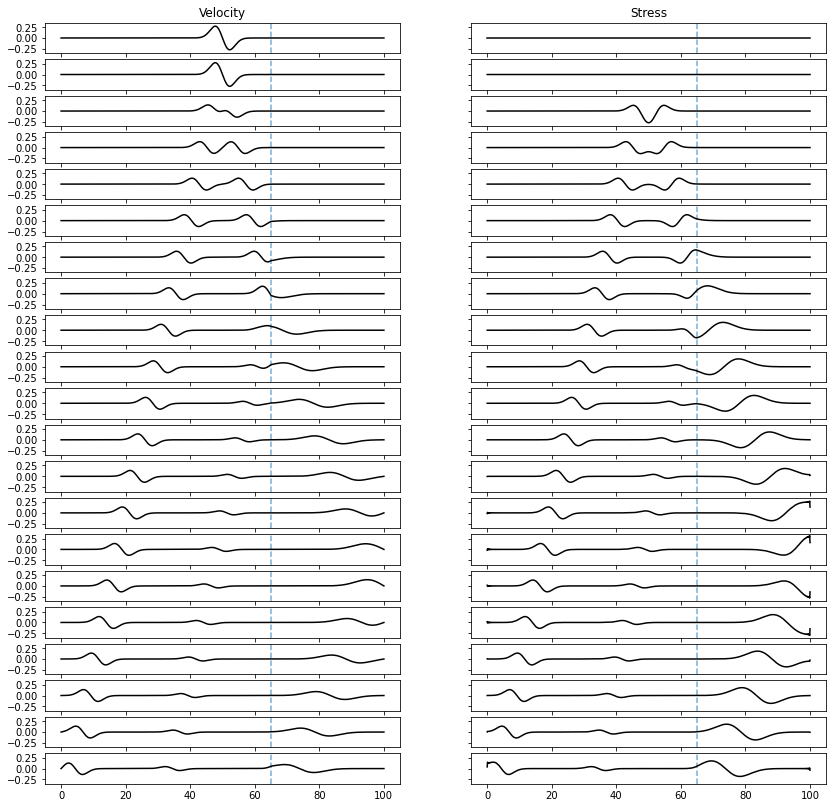

In [11]:
# Now we can re-run the system 
nplots = 20
fig, ax = plt.subplots(nplots+1, 2, figsize=(14, 14),sharey=True)

v, s       = init_condition(x, v, s)
vold, sold = init_condition(x, vold, sold)

ax[0,0].plot(x, v.real, 'k')
ax[0,1].plot(x, s.real, 'k')
ax[0,0].set_title('Velocity')
ax[0,1].set_title('Stress')
ax[0,0].set_ylim([-0.35, 0.35])

# Plot line demarking change in mu
for row in range(nplots+1):
    for col in range(2): 
        ax[row,col].axvline(65, linestyle='--', alpha=0.6)


kfft = np.fft.fftfreq(N, d=dx) * 2 * np.pi

iax    = 1
for istep in range(nsteps):

    vk = np.fft.fft(v)
    vgrad = np.fft.ifft(1j * kfft * vk)

    sk    = np.fft.fft(s)
    sgrad = np.fft.ifft(1j * kfft * sk)
    
    vnew = vold + ((2 * dt / rho)*sgrad)
    snew = sold + ((2 * dt * mu)*vgrad)
    
    # Dirichlet
    if dirichlet_bc: 
        v[0]     = 0
        v[-1]    = 0
        vnew[0]  = 0
        vnew[-1] = 0
    else: 
        s[0]     = 0
        s[-1]    = 0
        snew[0]  = 0
        snew[-1] = 0
    
    # Update arrays: 
    vold[:] = v[:]
    sold[:] = s[:]
    v[:]    = vnew[:].real
    s[:]    = snew[:].real

    
    # Plot every nth timestep 
    if istep % (nsteps/nplots) == 0:
        ax[iax,0].plot(x, v.real, 'k')
        ax[iax,1].plot(x, s.real, 'k')
        iax +=1